<a id=top-page></a>
# `pykitPIV` demo: Generate a temporal sequence of images

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#generate-particles">Generate particles</a></li>
    <li><a href="#generate-velocity-field">Generate random velocity field to advect the particles</a></li>
    <li><a href="#add-movement">Add movement to particles</a></li>
        <ul>
        <li><a href="#add-movement-update-time-sep">Update time separation</a></li>
        <li><a href="#add-movement-visualize">Visualize the PIV image pair</a></li>
        </ul>
    <li><a href="#save">Save the dataset</a></li>
    <li><a href="#upload">Upload the saved datasets</a></li>
</ol>
<p></p>
</div>
<br>

***

In [13]:
import numpy as np
import cmcrameri.cm as cmc
from pykitPIV import Particle, FlowField, Motion, Image

In [79]:
save_images = False
n_images = 1
image_size = (512, 512)
size_buffer = 50
origin = 'lower'
figsize = (6,3.5)
time_separation = 0.2
filename = None

<a id=generate-particles></a>
***

## Generate particles

[Go to the top](#top-page)

In [80]:
particles = Particle(n_images, 
                     size=image_size, 
                     size_buffer=size_buffer,
                     diameters=(2,3),
                     densities=(0.2,0.26),
                     diameter_std=0.5,
                     seeding_mode='random', 
                     random_seed=100)

In [81]:
image = Image(random_seed=100)

In [64]:
image.add_particles(particles)

Particles added to the image.


In [65]:
image.add_reflected_light(exposures=(0.6,0.65),
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/20)

Reflected light added to images I1.


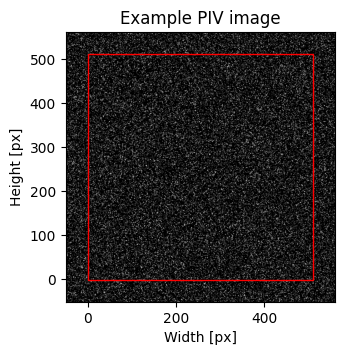

In [66]:
if save_images: filename = 'example-image.png'
image.plot(0, 
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image',
           cmap='Greys_r',
           origin=origin,
           figsize=figsize, 
           filename=filename);

<a id=generate-velocity-field></a>
***

## Generate random velocity field to advect the particles

[Go to the top](#top-page)

In [67]:
flowfield = FlowField(n_images,
                      size=image_size,
                      size_buffer=size_buffer,
                      random_seed=100)

In [68]:
flowfield.generate_random_velocity_field(gaussian_filters=(3,4),
                                         n_gaussian_filter_iter=20,
                                         displacement=(2,3))

In [69]:
image.add_flowfield(flowfield)

Velocity field added to the image.


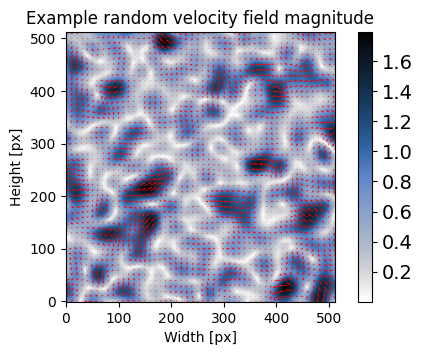

In [70]:
image.plot_field_magnitude(0,
                           with_buffer=False,
                           add_quiver=True,
                           quiver_step=10,
                           quiver_color='r',
                           xlabel='Width [px]',
                           ylabel='Height [px]',
                           title='Example random velocity field magnitude',
                           cmap=cmc.oslo_r,
                           figsize=figsize);

<a id=add-movement></a>
***

## Add movement to particles

[Go to the top](#top-page)

In [71]:
motion = Motion(particles, 
                flowfield, 
                time_separation=time_separation)

In [72]:
motion.forward_euler(n_steps=10)

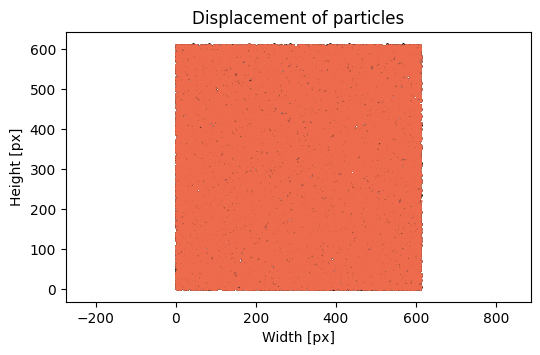

In [76]:
if save_images: filename = 'particle-displacement-1.png'
motion.plot_particle_motion(0,
                            s=1,
                            xlabel='Width [px]',
                            ylabel='Height [px]',
                            title='Displacement of particles',
                            figsize=figsize);

In [77]:
image.add_motion(motion)

Particle movement added to the image.


In [78]:
image.add_reflected_light(exposures=(0.6,0.65),
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/10)

Reflected light added to images I1.
Reflected light added to images I2.


In [43]:
current_I2 = [image.remove_buffers(image.images_I2)]

for i in range(0,40):

    print('t = ' + str(round((i+2)*time_separation),1) + 's')

    new_images_I1 = motion.particle_coordinates_I2
    
    particles.upload_particle_coordinates(new_images_I1)
    
    motion = Motion(particles, 
                flowfield, 
                time_separation=time_separation)
    
    motion.runge_kutta_4th(n_steps=4)
    
    image.add_motion(motion)
    image.add_reflected_light(exposures=(0.6,0.65),
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/10)

    current_I2.append(image.remove_buffers(image.images_I2))

t = 0.2s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.30000000000000004s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.4s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.5s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.6000000000000001s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.7000000000000001s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.8s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t = 0.9s
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
t 

***

## Animate

In [44]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
cmap = 'Greys_r'
filename='anim.gif'

In [45]:
def animate_evolution(imagelist):

    fig = plt.figure(figsize=figsize)

    im = plt.imshow(imagelist[0][0,0,:,:], cmap=cmap, origin=origin, animated=True)
    
    def updatefig(j):

        im.set_array(imagelist[j][0,0,:,:])

        return [im]
    
    anim = animation.FuncAnimation(fig, updatefig, frames=range(len(current_I2)), interval=1, blit=True)
    
    anim.save(filename, fps=20, bitrate=-1, dpi=300, savefig_kwargs={'bbox_inches' : 'tight'})
    
    return anim

MovieWriter ffmpeg unavailable; using Pillow instead.


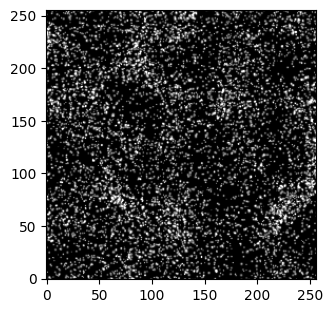

In [46]:
animate_evolution(current_I2)

***

© K. Zdybał, C. Mucignat, I. Lunati (2024)